# Nodal-line semimetalにおけるQMD項の寄与の確認

In [2]:
#using LinearAlgebra
using Plots

In [3]:
using Distributed
addprocs(30)

30-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
  ⋮
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31

In [4]:
@everywhere using LinearAlgebra

In [5]:
module NLSM
    using Distributed
    #Parm(t,p0,v,mu,Delta,eta,T,K_SIZE,W_MAX, W_SIZE)
    @everywhere struct Parm
        t::Float64
        p0::Float64
        v::Float64
        mu::Float64
        Delta::Float64
        eta::Float64
        T::Float64
        K_SIZE::Int
        W_MAX::Float64
        W_SIZE::Int
    end

    @everywhere mutable struct Hamiltonian
        Hk::Array{ComplexF64,2}
        Vx::Array{ComplexF64,2}
        Vy::Array{ComplexF64,2}
        Vz::Array{ComplexF64,2}
        Vxx::Array{ComplexF64,2}
        Vyx::Array{ComplexF64,2}
        Vyy::Array{ComplexF64,2}
        Vxz::Array{ComplexF64,2}
        Vyz::Array{ComplexF64,2}
        Vzz::Array{ComplexF64,2}
        E::Array{Float64,1}
    end

    @everywhere mutable struct Green
        GR::Array{ComplexF64,2}
        GA::Array{ComplexF64,2}
        GRmA::Array{ComplexF64,2}
        dGR::Array{ComplexF64,2}
    end
end

Main.NLSM

In [6]:
using .NLSM

In [7]:
@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    
    return GR, GA, GRmA, dGR
end
@everywhere function Gk_M(M::Int, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + pi*p.T*(2*M+1)*Matrix{Complex{Float64}}(I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA0::Array{ComplexF64,2} = -Ham.Hk + 1.0im*pi*p.T*(2*M+1)*Matrix{Complex{Float64}}(I,2,2) - p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)    
    GA::Array{ComplexF64,2} = inv(GA0)
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    
    return GR, GA, GRmA, dGR
end

@everywhere function HV_BI(H::Hamiltonian)

    H.E, BI::Array{ComplexF64,2} = eigen(H.Hk)
    Vx_BI::Array{ComplexF64,2} = BI' * H.Vx * BI
    Vy_BI::Array{ComplexF64,2} = BI' * H.Vy * BI
    Vz_BI::Array{ComplexF64,2} = BI' * H.Vz * BI
    Vxx_BI::Array{ComplexF64,2} = BI' * H.Vxx * BI
    Vyx_BI::Array{ComplexF64,2} = BI' * H.Vyx * BI
    Vyy_BI::Array{ComplexF64,2} = BI' * H.Vyy * BI
    Vxz_BI::Array{ComplexF64,2} = BI' * H.Vxz * BI
    Vyz_BI::Array{ComplexF64,2} = BI' * H.Vyz * BI
    Vzz_BI::Array{ComplexF64,2} = BI' * H.Vzz * BI
    

    H.Vx = Vx_BI
    H.Vy = Vy_BI
    H.Vz = Vz_BI
    H.Vxx = Vxx_BI
    H.Vyx = Vyx_BI
    H.Vyy = Vyy_BI
    H.Vxz = Vxz_BI
    H.Vyz = Vyz_BI
    H.Vzz = Vzz_BI
end
@everywhere f(e::Float64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::Float64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function f(e::ComplexF64,T::Float64)
    FD::ComplexF64 = 1.0/(1.0+exp(e/T))
    return FD
end
@everywhere function df(e::ComplexF64,T::Float64)
    dFD::ComplexF64 = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T
    return dFD
end

@everywhere function Green_XXX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XYY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vy[i,i]*H.Vy[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vy[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end

    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

In [8]:

@everywhere function Green_XX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    Drude0::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    app_QM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Drude0 += -real(H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)
        BC += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(f(H.E[i]+1.0im*p.eta, p.T))
        dQM += 2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(f(H.E[i]+1.0im*p.eta, p.T))
        app_QM += 2.0*p.eta*real(H.Vx[i,3-i]*H.Vx[3-i,i])/((H.E[i]-H.E[3-i])^2+4.0*p.eta^2)*(-df(H.E[i], p.T))
    end
    return Drude, Drude0, BC, dQM, app_QM
end
@everywhere function Green_DCL_2D(p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    dw::Float64 = p.W_MAX/p.W_SIZE/pi
    for w in collect(-p.W_MAX:2.0p.W_MAX/p.W_SIZE:p.W_MAX)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        XX += real(tr(H.Vx*G.GR*H.Vx*G.GRmA))*df(w,p.T)
    end
    return dw*XX
end

In [8]:
@everywhere sigma = [[1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], [0.0 -1.0im; 1.0im 0.0], [1.0 0.0; 0.0 -1.0]]
@everywhere function HandV(k::NTuple{3, Float64},p::Parm)

    eps::Float64 = p.mu
    g_x::Float64 = p.Delta
    g_y::Float64 = p.v*sin(k[3])
    g_z::Float64 = p.t*(2.0 + cos(p.p0) -cos(k[1]) - cos(k[2]) -cos(k[3]))
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  gg' * sigma

    eps_vx::Float64 = 0.0
    gx_vx::Float64 = 0.0
    gy_vx::Float64 = 0.0
    gz_vx::Float64 = p.t*sin(k[1])
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = gg_x' * sigma


    eps_vy::Float64 = 0.0
    gx_vy::Float64 = 0.0
    gy_vy::Float64 = 0.0
    gz_vy::Float64 = p.t*sin(k[2])
    gg_y = [eps_vy, gx_vy, gy_vy, gz_vy]
    Vy::Array{ComplexF64,2} = gg_y' * sigma

    eps_vz::Float64 = 0.0
    gx_vz::Float64 = 0.0
    gy_vz::Float64 = p.v*cos(k[3])
    gz_vz::Float64 = p.t*sin(k[3])
    gg_z = [eps_vz, gx_vz, gy_vz, gz_vz]
    Vz::Array{ComplexF64,2} = gg_z' * sigma

    Vxx::Array{ComplexF64,2} = sigma[3].*p.t*cos(k[1])
    
    Vyy::Array{ComplexF64,2} = sigma[3].*p.t*cos(k[2])

    Vyx::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    Vxz::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]
    
    Vyz::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    Vzz::Array{ComplexF64,2} = sigma[3].*p.t*cos(k[3]) - sigma[2].*p.v*sin(k[3])

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vz, Vxx, Vyx, Vyy, Vxz, Vyz, Vzz, E 
end

In [84]:
@everywhere function Green_XX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(2.0*H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)

        BC += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(f(H.E[i]+1.0im*p.eta, p.T))
        dQM += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(f(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM
end

@everywhere function Green_ZZ_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    
    HV_BI(H)
    println(H.Vz)

    for i = 1:2
        Drude += -real(2.0*H.Vz[i,i]*H.Vz[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)

        BC += -2.0imag(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        dQM += -2.0real(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        #BC += -imag(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        #dQM += -real(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM
end

@everywhere function Green_ZZ_BI2(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    
    #HV_BI(H)

    for i = 1:2
        Drude += -real(2.0*H.Vz[i,i]*H.Vz[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)

        #BC += -2.0imag(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        #dQM += -2.0real(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        BC += -imag(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dQM += -real(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM
end

@everywhere function Green_ZZ_BI_im0(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BC::Float64 = 0.0
    #dQM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(2.0*H.Vz[i,i]*H.Vz[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)

        #BC += -2.0imag(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        #dQM += -2.0real(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        BC += -imag(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i], p.T))
        #dQM += -real(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC
end

In [95]:
@everywhere function Green_DCL_2D(p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    dw::Float64 = 7.0p.T/p.W_SIZE/pi
    for w in collect(-7.0p.T:14.0p.T/p.W_SIZE:7.0p.T)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        XX += real(tr(H.Vz*G.GR*H.Vz*G.GRmA))*df(w,p.T)
    end
    return dw*XX
end
@everywhere function Green_DCL_2D_F(p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    dw::Float64 = (p.W_MAX+4.0p.T)/p.W_SIZE/(2.0*pi)
    for w in collect(-p.W_MAX:(p.W_MAX+4.0p.T)/p.W_SIZE:4.0p.T)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        XX += -2.0real(tr(H.Vz*G.dGR*H.Vz*G.GRmA))*f(w,p.T)
    end
    return dw*XX
end

In [102]:
p_test = Parm(0.5, pi/2, 0.2, 0.0, 0.0, 0.02, 0.1, 400, 1.0, 500)
k_test = (0.0, 0.0, pi/2)
H_test = Hamiltonian(HandV(k_test,p_test)...)
println(Green_DCL_2D(p_test,H_test))
println(Green_DCL_2D_F(p_test,H_test))

0.14607717856748567
0.14604940426993374


In [105]:
df(0.00001+0.1im,0.02)

-19.475525652144672 - 0.0072743260584602915im

In [137]:
@everywhere function Green_ZZ_BI_check(p::Parm, H::Hamiltonian)
    Drude::Array{Float64,1} = zeros(2)
    BC::Array{Float64,1} = zeros(2)
    dQM::Array{Float64,1} = zeros(2)
    tot::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude[i] += 2.0real(H.Vz[i,i]*H.Vz[i,i])*real(f(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        BC[i] += -2.0imag(real(H.Vz[i,3-i]*H.Vz[3-i,i])/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        dQM[i] += -2.0real(real(H.Vz[i,3-i]*H.Vz[3-i,i])/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        tot += -2.0imag(real(H.Vz[i,3-i]*H.Vz[3-i,i])/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)*f(H.E[i]+1.0im*p.eta, p.T))
        #BC += -imag(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        #dQM += -real(H.Vz[i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM, tot
end

@everywhere function Green_ZZ_BI2_check(p::Parm, H::Hamiltonian)
    Drude::Array{Float64,1} = zeros(2)
    BC::Array{Float64,1} = zeros(2)
    dQM::Array{Float64,1} = zeros(2)
    tot::Float64 = 0.0
    
    #HV_BI(H)

    for i = 1:2
        Drude[i] += -real(H.Vz[i,i]*H.Vz[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)

        #BC += -2.0imag(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        #dQM += -2.0real(H.Vz[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        BC[i] += -imag(real(H.Vz[i,3-i]*H.Vz[3-i,i])/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dQM[i] += -real(real(H.Vz[i,3-i]*H.Vz[3-i,i])/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
        tot += -imag(real(H.Vz[i,3-i]*H.Vz[3-i,i])/(H.E[i]-H.E[3-i]+2.0im*p.eta)*df(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM, tot
end

In [139]:
p_test = Parm(0.5, pi/2, 0.2, 0.0, 0.0, 0.01, 1000, 400, 1.0, 500)
k_test = (0.0, 0.0, pi/2)
H_test = Hamiltonian(HandV(k_test,p_test)...)
println(Green_ZZ_BI_check(p_test,H_test))
println(Green_ZZ_BI2_check(p_test,H_test))


([3.08179605980966e-29, 3.081179762229494e-29], [-0.07774362799358107, 0.07772804195872017], [-0.07773583497620255, 0.07773583497609865], -1.558603496484845e-5)
([1.5407439401408674e-34, 1.5407439401408674e-34], [-7.79301737862375e-6, -7.79301737862375e-6], [-1.558603470541403e-13, -1.5586034705408524e-13], -1.5586035068968196e-5)


In [136]:
println(H_test.E)
(H_test.E[1]-H_test.E[3-1]+2.0im*p_test.eta)

[-0.2, 0.2]


-0.4 + 0.02im

In [132]:
println(BC[1] + BC[2] -QM[1] -QM[2])
println(BC2[1] + BC2[2] -QM2[1] -QM2[2])

-0.00013568672987122608
0.0012325697809929732


In [67]:
mu0 = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075,0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]
#collect(-0.2:0.02:0.2)
#collect(-0.2:0.01:0.01)
#DrudeX_mu = zeros(Float64,length(mu0))
#BCX_mu = zeros(Float64,length(mu0))
#dQMX_mu = zeros(Float64,length(mu0))
Drude0_mu = zeros(Float64,length(mu0))
BC0_mu = zeros(Float64,length(mu0))
#Green_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm(t,p0,v,mu,Delta,eta,T,K_SIZE,W_MAX, W_SIZE)
    p = Parm(0.5, pi/2, 0.2, 0.0, 0.0,mu0[j], 0.02, 400, 1.0, 500)

    k2 = collect(Iterators.product((-pi:2pi/p.K_SIZE:pi)[1:end-1], (-pi:2pi/p.K_SIZE:pi)[1:end-1]))
    for kz in collect(-pi:2pi/p.K_SIZE:pi)[1:end-1]
        Dr0::Float64 = 0.0
        BC0::Float64 = 0.0
        dQM0::Float64 = 0.0
        Dr00::Float64 = 0.0
        BC00::Float64 = 0.0
        #Green0::Float64 = 0.0
        #Dr0, BC0, dQM0, 
        Dr00, BC00 = @distributed (+) for i in 1:length(k2)
        #, Green0 = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian(HandV(k,p)...)
            #Gr = Green_DC_2D(p,Hamk)
            Dr, BC = Green_ZZ_BI_im0(p,Hamk)
            #Dr, BC, dQM = Green_ZZ_BI(p,Hamk)
            [Dr/(p.K_SIZE^3), BC/(p.K_SIZE^3)]
            #[Dr/(p.K_SIZE^3), BC/(p.K_SIZE^3), dQM/(p.K_SIZE^3), Gr/(p.K_SIZE^3)]
        end
        Drude0_mu[j] += Dr00
        BC0_mu[j] += BC00
        #DrudeX_mu[j] += Dr0
        #BCX_mu[j] += BC0
        #dQMX_mu[j] += dQM0
        #Green_mu[j] += Green0
    end
end

In [18]:
using Plots
Plots.scalefontsizes(1.4)

In [30]:
println(DrudeX_mu)

[0.2633655088170011, 0.1266346004133697, 0.0787287910217644, 0.05292271938109564, 0.035817372045769735, 0.022878132834194046, 0.012064807586164643, 0.002203796336657363, -0.00763469684494236, -0.018611903938943734, -0.033251283394429426, -0.06408953929677681, -0.0673203799837427, -0.02847284560720982, -0.013682386182138085, -0.005133545854465137, 0.004248664909384462, 0.008704826956342938, 0.010607883645617594, 0.010934061428399384, 0.010161336007232506, 0.008531038231200569, 0.0061305252505083506, 0.002880868346148128]


In [56]:
println(length(mu0))


Green_mu = [0.2833655088170011/2, 0.078788717, 0.060268291, 0.05, 0.048917633, 0.047424071, 0.047084623, 0.047440404, 0.048233647, 0.049307527, 0.050559624, 0.051920234, 0.053339527, 0.054781415, 0.05621876, 0.05763141, 0.060324836, 0.062780152, 0.064954704, 0.066831345, 0.06840941, 0.069699328, 0.070718228, 0.0714874]


24


24-element Vector{Float64}:
 0.14168275440850056
 0.078788717
 0.060268291
 0.05
 0.048917633
 0.047424071
 0.047084623
 0.047440404
 0.048233647
 0.049307527
 0.050559624
 0.051920234
 0.053339527
 0.054781415
 0.05621876
 0.05763141
 0.060324836
 0.062780152
 0.064954704
 0.066831345
 0.06840941
 0.069699328
 0.070718228
 0.0714874

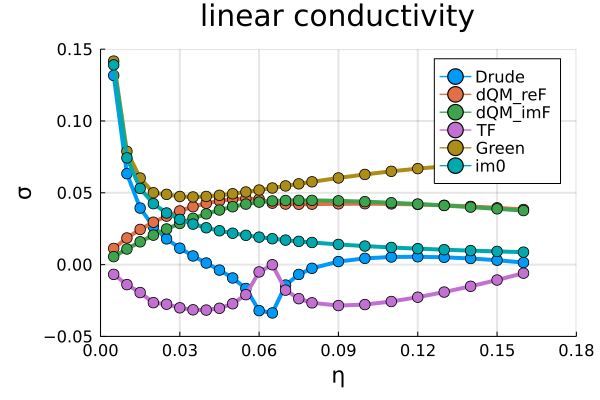

In [68]:

plot(mu0, 0.5*DrudeX_mu, label="Drude",xlabel="η",xlims=(0,0.18), ylim=(-0.05,0.15),ylabel="σ",title="linear conductivity", width=4.0, marker=:circle, markersize = 6.0,margin=Plots.Measures.Length(:mm, 4.0),gridlinewidth=2.0)
plot!(mu0, -BCX_mu, label="dQM_reF", width=4.0, marker=:circle, markersize = 6.0)
plot!(mu0, -dQMX_mu, label="dQM_imF", width=4.0, marker=:circle, markersize = 6.0)
plot!(mu0, Green_mu-(0.5*DrudeX_mu-BCX_mu-dQMX_mu), label="TF", width=4.0, marker=:circle, markersize = 6.0)
plot!(mu0, Green_mu, label="Green", width=4.0, marker=:circle, markersize = 6.0)
plot!(mu0, 0.5*Drude0_mu-BC0_mu, label="im0", width=4.0, marker=:circle, markersize = 6.0)

In [70]:
mu1 = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.12]
#collect(-0.2:0.02:0.2)
#collect(-0.2:0.01:0.01)
DrudeX_mu2 = zeros(Float64,length(mu1))
BCX_mu2 = zeros(Float64,length(mu1))
dQMX_mu2 = zeros(Float64,length(mu1))
#Green_mu = zeros(Float64,length(mu0))

for j in 1:length(mu1)
    #Parm(t,p0,v,mu,Delta,eta,T,K_SIZE,W_MAX, W_SIZE)
    p = Parm(0.5, pi/2, 0.2, 0.0, 0.0,mu1[j], 0.02, 1500, 1.0, 500)

    k2 = collect(Iterators.product((0:pi/p.K_SIZE:pi)[1:end-1], (0:pi/p.K_SIZE:pi)[1:end-1]))
    for kz in collect(0:pi/p.K_SIZE:pi)[1:end-1]
        Dr0::Float64 = 0.0
        BC0::Float64 = 0.0
        dQM0::Float64 = 0.0
        #Green0::Float64 = 0.0
        Dr0, BC0, dQM0 = @distributed (+) for i in 1:length(k2)
        #, Green0 = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian(HandV(k,p)...)
            #Gr = Green_DC_2D(p,Hamk)
            Dr, BC, dQM = Green_ZZ_BI(p,Hamk)
            [Dr/(p.K_SIZE^3), BC/(p.K_SIZE^3), dQM/(p.K_SIZE^3)]
            #[Dr/(p.K_SIZE^3), BC/(p.K_SIZE^3), dQM/(p.K_SIZE^3), Gr/(p.K_SIZE^3)]
        end
        DrudeX_mu2[j] += 8*Dr0
        BCX_mu2[j] += 8*BC0
        dQMX_mu2[j] += 8*dQM0
        #Green_mu[j] += Green0
    end
end

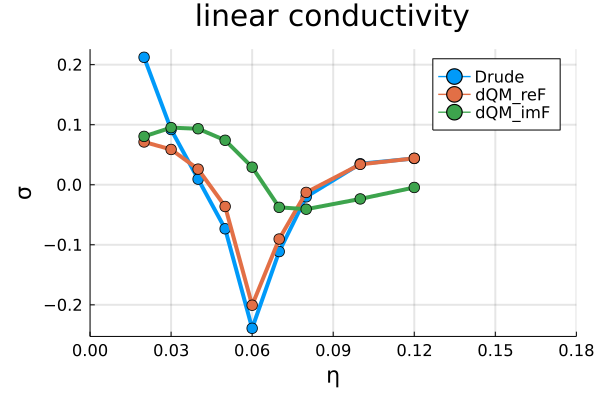

In [72]:
plot(mu1, 0.5*DrudeX_mu2, label="Drude",xlabel="η",xlims=(0,0.18),ylabel="σ",title="linear conductivity", width=4.0, marker=:circle, markersize = 6.0,margin=Plots.Measures.Length(:mm, 4.0),gridlinewidth=2.0)
plot!(mu1, -BCX_mu2, label="dQM_reF", width=4.0, marker=:circle, markersize = 6.0)
plot!(mu1, -dQMX_mu2, label="dQM_imF", width=4.0, marker=:circle, markersize = 6.0)
#plot!(mu1, Green_mu2-(0.5*DrudeX_mu2-BCX_mu2-dQMX_mu2), label="TF", width=4.0, marker=:circle, markersize = 6.0)
#plot!(mu1, Green_mu2, label="Green", width=4.0, marker=:circle, markersize = 6.0)

In [16]:

@everywhere function Green_XX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    Drude0::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    app_QM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Drude0 += -real(H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)
        BC += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(f(H.E[i]+1.0im*p.eta, p.T))
        dQM += 2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(f(H.E[i]+1.0im*p.eta, p.T))
        app_QM += 2.0*p.eta*real(H.Vx[i,3-i]*H.Vx[3-i,i])/((H.E[i]-H.E[3-i])^2+4.0*p.eta^2)*(-df(H.E[i], p.T))
    end
    return Drude, Drude0, BC, dQM, app_QM
end
@everywhere function Green_DCL_2D(p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    dw::Float64 = p.W_MAX/p.W_SIZE/pi
    for w in collect(-p.W_MAX:2.0p.W_MAX/p.W_SIZE:p.W_MAX)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        XX += 2.0real(tr(H.Vx*G.GR*H.Vx*G.GRmA))*df(w,p.T)
    end
    return dw*XX
end

In [17]:
mu0 = [0.005, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.08, 0.1]
#mu0 = [-0.1,-0.08, -0.06, -0.04, -0.02, 0.0, 0.02]
Drude2_mu = zeros(Float64,length(mu0))
BC_mu2 = zeros(Float64,length(mu0))
dQM_mu2 = zeros(Float64,length(mu0))
#Green_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_in, W_MAX, W_SIZE
    p = Parm(5.0, 0.5, 0.0, 0.2, 0.0, 0.0, 0.02, mu0[j], 1.0, 800, 0, 0.5, 500)
    if j == 1
        println(p)
    end
    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    Drude_mu2[j], BC_mu2[j], dQM_mu2[j], Green_mu[j] = @distributed (+) for i in 1:length(k2)
        Hamk = Hamiltonian(HandV_topo(k2[i],p)...)
        Green0 = Green_DCL_2D(p,Hamk)
        Drude0, BC0, dQM0, app0 = Green_XX_BI(p,Hamk)
        [Drude0/(p.K_SIZE^2), BC0/(p.K_SIZE^2), dQM0/(p.K_SIZE^2), Green0/(p.K_SIZE^2)]
    end
end

Parm(5.0, 0.5, 0.0, 0.2, 0.0, 0.0, 0.02, 0.005, 1.0, 500, 0.0, 0.5, 1000)


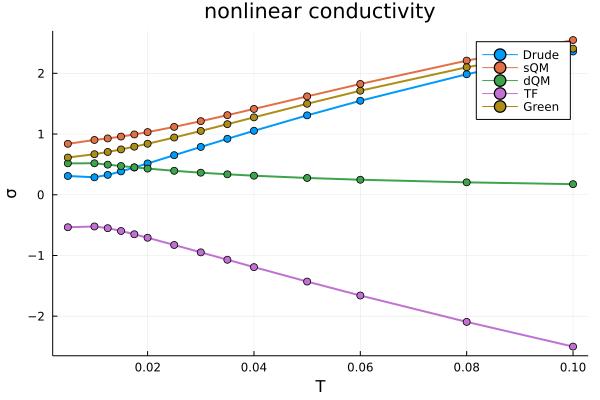

In [19]:
plot(mu0, Drude_mu, label="Drude",xlabel="T",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BC_mu+dQM_mu, label="sQM", width=2.0, marker=:circle)
plot!(mu0, dQM_mu, label="dQM", width=2.0, marker=:circle)
plot!(mu0, Green_mu/2-Drude_mu-BC_mu-dQM_mu, label="TF", width=2.0, marker=:circle)
plot!(mu0, Green_mu/2, label="Green", width=2.0, marker=:circle)
#    savefig(p1,"./T_dep_ZZ.png")

In [27]:
p_test = Parm(5.0, 0.5, 0.0, 0.2, 0.0, 0.0, 0.02, 0.04, 1.0, 500, 0, 0.5, 1000)
k_test = (0.0,1.5)
H_test = Hamiltonian(HandV_topo(k_test,p_test)...)
println(H_test.Hk)
println(H_test.Vx)
HV_BI(H_test)
println(H_test.Hk)
println(H_test.Vx)

ComplexF64[0.225 + 0.0im -0.75 - 0.2im; -0.75 + 0.2im 0.225 + 0.0im]
ComplexF64[0.0 + 0.0im 0.0 - 0.5im; 0.0 + 0.5im 0.0 + 0.0im]
ComplexF64[-0.551208734813001 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0012087348130012 + 0.0im]
ComplexF64[-0.12883132528016616 + 0.0im 0.0 - 0.48311746980062303im; 0.0 + 0.48311746980062303im 0.12883132528016616 + 0.0im]


In [15]:
@everywhere function TFterm_XX(p::Parm, H::Hamiltonian)
    TF::Float64 = 0.0
    for i = 1:p.W_SIZE
        g = Green(Gk_M(i,p,H)...)
        TF += p.T * real(-2.0im*tr(H.Vx*g.dGR*H.Vx*g.GRmA))
    end
    return TF    
end

@everywhere function TFterm_ZZ(p::Parm, H::Hamiltonian)
    TF::Float64 = 0.0
    for i = 1:p.W_SIZE
        g = Green(Gk_M(i,p,H)...)
        TF += p.T * real(-2.0im*tr(H.Vz*g.dGR*H.Vz*g.GRmA))
    end
    return TF    
end

@everywhere function Green_DC_2D(p::Parm, H::Hamiltonian)
    ZZ::Float64 = 0.0
    dw::Float64 = p.W_MAX/p.W_SIZE/pi
    for w in collect(-p.W_MAX:2.0p.W_MAX/p.W_SIZE:p.W_MAX)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        ZZ += real(tr(H.Vz*G.GR*H.Vz*G.GRmA))*df(w,p.T)
    end
    return dw*ZZ
end

In [40]:
mu0 = [-0.1, -0.075, -0.05, -0.025, 0.0, 0.025]
Drude_mu = zeros(Float64,length(mu0))
BC_mu = zeros(Float64,length(mu0))
dQM_mu = zeros(Float64,length(mu0))
TF_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: t, p0, v, Delta, eta, T, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.5, 0.0, 0.2, mu0[j], 0.0, 0.03, 0.02, 250, 1.0, 500)

    k2 = collect(Iterators.product((-pi:2pi/p.K_SIZE:pi)[1:end-1], (-pi:2pi/p.K_SIZE:pi)[1:end-1]))
    for kz in collect(-pi:2pi/p.K_SIZE:pi)[1:end-1]
        Dr0::Float64 = 0.0
        BC0::Float64 = 0.0
        dQM0::Float64 = 0.0
        TF0::Float64 = 0.0
        Dr0, BC0, dQM0, TF0 = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian(HandV(k,p)...)
            Dr, BC, dQM = Green_ZZ_BI(p,Hamk)
            TF = TFterm_ZZ(p,Hamk)
            [Dr/(p.K_SIZE^3), BC/(p.K_SIZE^3), dQM/(p.K_SIZE^3), TF/(p.K_SIZE^3)]
        end
        Drude_mu[j] += Dr0
        BC_mu[j] += BC0
        dQM_mu[j] += dQM0
        TF_mu[j] += TF0
    end
end

In [33]:
Drude_mu

6-element Vector{Float64}:
  0.04544794871848953
  0.0312752096040379
  0.018960290446560762
  0.008584757857638438
 -0.0003037059623710532
  0.008584757857638436

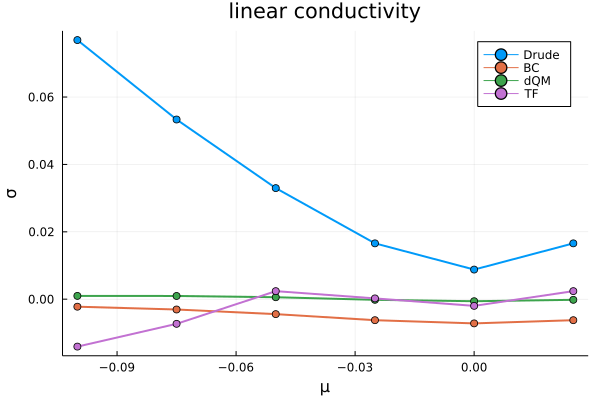

In [41]:
#using Plots
plot(mu0, Drude_mu, label="Drude",xlabel="μ",ylabel="σ",title="linear conductivity", width=2.0, marker=:circle)
plot!(mu0, BC_mu, label="BC", width=2.0, marker=:circle)
plot!(mu0, dQM_mu, label="dQM", width=2.0, marker=:circle)
plot!(mu0, TF_mu, label="TF", width=2.0, marker=:circle)


In [26]:
(DrudeX_mu, BCX_mu, dQMX_mu)

([0.14777325885779222], [-0.017606026715282615], [0.0024676582323986886])

In [49]:
p0 = Parm(0.5, pi/3, 0.2, 0, 0.0, 0.02, 0.01, 250, 1.0, 100)
k0 = (pi/3,0.0,0.0)
H0 = Hamiltonian(HandV(k0,p0)...)
Dru, BCu, dQMe = Green_ZZ_BI(p0,H0)
println(H0.E)
println(Dru)
println(BCu)
println(dQMe)

[0.0, 0.0]
0.0
0.0
-77.87038623274512
